# **MScFE 642 DEEP LEARNING FOR FINANCE**
## **Group Work Project** # 3
### **Student Group** 8422
### *Atakan Devrent, Mukiza Rayner*

# Step 1

### a) **Picking a time series - VIX**

In this step we'll be exploring the VIX index from **2022** to **2025**.

The VIX Index, or "fear gauge," is an estimate of the market's expectation of volatility in the future as implied from S&P 500 index options. It is calculated from the implied volatility of SPX near-term options and is the estimated annualized change in the S&P 500 over the next 30 days.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from datetime import date, timedelta
import statsmodels
import scipy.stats as stats
import torch
from torch import nn
import torchinfo

In [44]:
end_date = date(2025, 2, 10)
start_date = date(2022, 2, 10)
ticker = "^VIX"

# Get the data
vix =yf.Ticker(ticker)
data = vix.history(
        start=start_date,
        end=end_date,
        auto_adjust=False
    )

# Drop extra columns
data = data.loc[:, ["Adj Close"]]

#### **Visual Exploration of the Time series**

Here we would like to visualize the data to get a visual sense of the implied vol evolution.

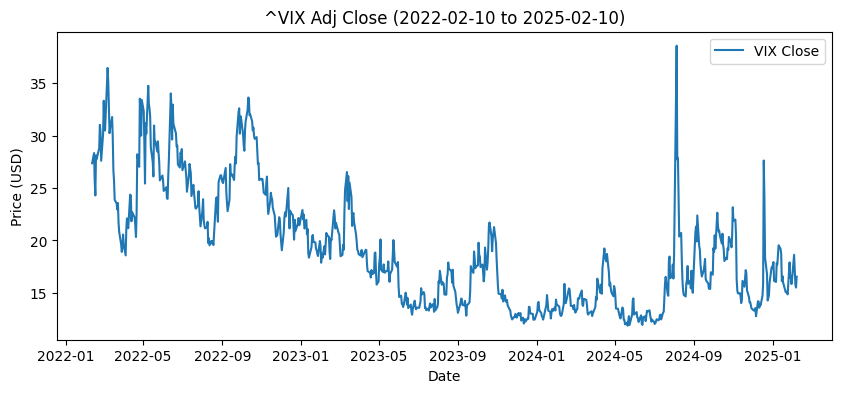

In [42]:
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.plot(data['Adj Close'], label="VIX Close")
plt.title(f'{ticker} Adj Close ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#### **Summary Statistics**

In [6]:
from scipy.stats import skew, kurtosis

print("Summary Statistics:")
display(data['Adj Close'].describe())

# Skew and Kurtosis
print("\nSkew and Kurtosis:")
print(f"Skewness: {skew(data['Adj Close'])}")
print(f"Kurtosis: {kurtosis(data['Adj Close'])}")

Summary Statistics:


count    750.00000
mean      19.14316
std        5.65568
min       11.86000
25%       14.32250
50%       17.89500
75%       22.54250
max       38.57000
Name: Adj Close, dtype: float64


Skew and Kurtosis:
Skewness: 0.8385089848603924
Kurtosis: -0.13083867316170394


#### **Distribution Analysis**

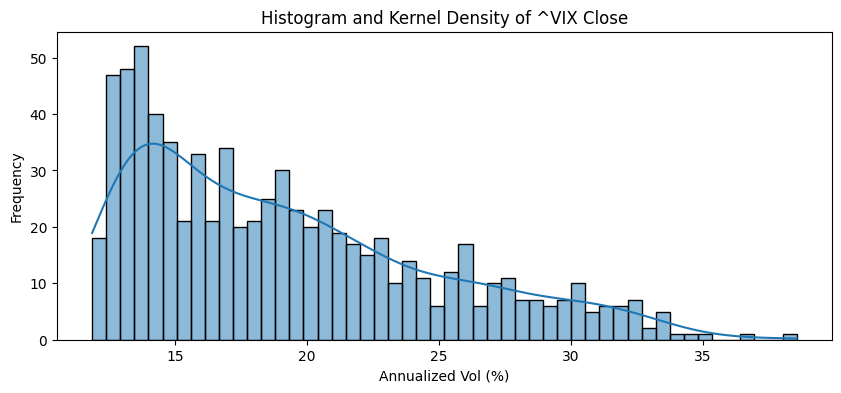

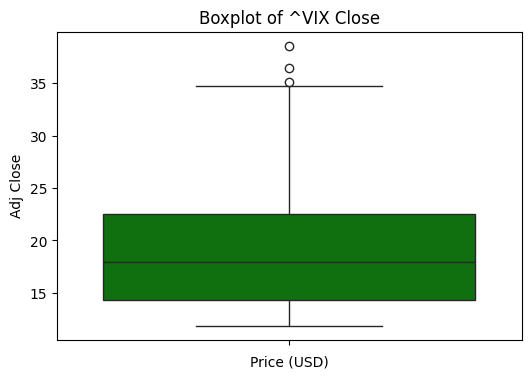

In [ ]:
import seaborn as sns

# Histogram and KDE
plt.figure(figsize=(10, 4))
sns.histplot(
    data=data['Adj Close'].dropna(),
    kde=True,
    bins=50
)
plt.title(f'Histogram and Kernel Density of {ticker} Close')
plt.xlabel('Annualized Vol (%)')
plt.ylabel('Frequency')
plt.show()

# Boxplot to check for outliers
plt.figure(figsize=(6,4))
sns.boxplot(
    data=data['Adj Close'].dropna(),
    color='green'
)
plt.title(f'Boxplot of {ticker} Close')
plt.xlabel('Price (USD)')
plt.show()

#### **Stationarity Tests**

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    print(f'Augmented Dickey-Fuller Test')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF Test Statistic', 'p-values', 'Number of Lags Used', 'Number of Observations Used']
    out = dict(zip(labels, result[0:4]))

    for key, val in out.items():
        print(f"    {key}:{val}")

    for key, val in result[4].items():
        print(f"   Critical Value {key}:{val}")

    print("-"*40)


adf_test(data['Adj Close'])

Augmented Dickey-Fuller Test
    ADF Test Statistic:-3.6611275590538135
    p-values:0.004694368656609763
    Number of Lags Used:1
    Number of Observations Used:748
   Critical Value 1%:-3.43912257105195
   Critical Value 5%:-2.8654117005229844
   Critical Value 10%:-2.568831705010152
----------------------------------------


#### **Autocorrelation and Partial Autocorrelation**

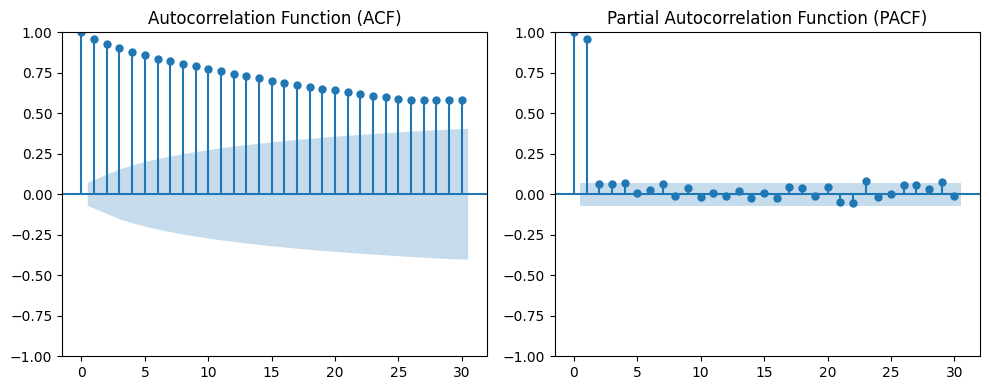

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation & Partial Autocorrelation
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plot_acf(data['Adj Close'].dropna(), ax=plt.gca(), lags=30)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1,2,2)
plot_pacf(data['Adj Close'].dropna(), ax=plt.gca(), lags=30,method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### **b, c) Build, Train & Test the Predictive Models, MLP and LSTM**

For the **MLP**, we will use the N-BEATS architecture of *Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio*, from our **GWP1**, which is demonstrating spectacular success for prediction-related issues in univariate time series domain. N-BEATS is so robust a time series forecasting deep learning structure because it leverages the capability of employing an easily interpretable yet highly expressive fully connected network irrespective of time-series-based feature engineering. Its block-wise design, where each block provides both backcast and forecast, allows iterative residual learning that improves the prediction step by step in each iteration. The doubly residual stacking of the proposed architecture can effectively backpropagate gradients and allows the model to decompose the input signal into useful components, i.e., trend and seasonality, without sacrificing performance. All this with flexibility, interpretability, and cutting-edge accuracy across a broad spectrum of forecasting benchmarks, which makes N-BEATS a compelling solution for time series analysis.



(Reference: https://arxiv.org/abs/1905.10437 - *N-BEATS: Neural basis expansion analysis for interpretable time series forecasting, Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio*)

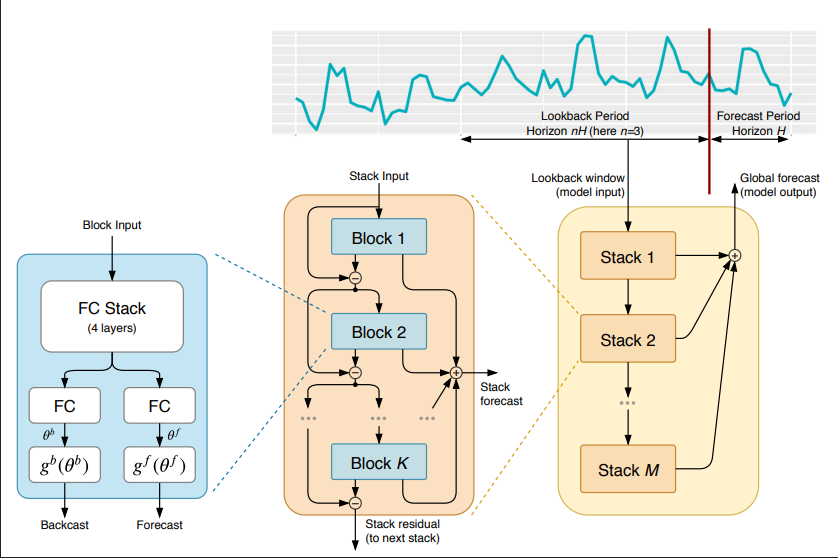

In [12]:
class NBEATSBlock(nn.Module):
    def __init__(self, H, n, dropout_prob=0.1):
        """
        Parameters:
        H (int): Forecast horizon (number of future time steps to predict)
        n (int): How many times the forecast horizon to look back
        """
        super().__init__()
        self.stem = nn.Sequential(  # input size: (batch_size, 1, H*n)
            nn.Linear(in_features=H*n, out_features=512), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(in_features=512, out_features=1024), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(in_features=1024, out_features=512), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(in_features=512, out_features=256), nn.ReLU()
        )

        # In generic architecture, the backcast and forecast transformations are just linear layers
        self.backcast = nn.Linear(in_features=256, out_features=H*n)
        self.forecast = nn.Linear(in_features=256, out_features=H)

    def forward(self, x):
        x = self.stem(x)
        x_bc = self.backcast(x)
        x_fc = self.forecast(x)

        return x_bc, x_fc
    
class NBEATSStack(nn.Module):
    def __init__(self, K, H, n):
        """
        Parameters:
        K (int): Number of blocks in the stack
        H (int): Forecast horizon (number of future time steps to predict)
        n (int): How many times the forecast horizon to look back
        """
        super().__init__()
        self.blocks = nn.ModuleList([NBEATSBlock(H, n) for _ in range(K)])

    def forward(self, x):
        x_fc_sum = torch.zeros(x.size(0), H, dtype=x.dtype).to(x.device)
        residual = x  # start with the original input
        for block in self.blocks:
            x_bc, x_fc = block(residual)
            residual = residual - x_bc  # update residual using the block’s input
            x_fc_sum += x_fc
        return residual, x_fc_sum
    
class NBEATS(nn.Module):
    def __init__(self, M, K, H, n):
        """
        Parameters:
        M (int): Number of stacks in the network
        K (int): Number of blocks in the stack
        H (int): Forecast horizon (number of future time steps to predict)
        n (int): How many times the forecast horizon to look back
        """
        super().__init__()
        self.H = H
        self.stacks = nn.ModuleList([NBEATSStack(K, H, n) for _ in range(M)])

    def forward(self, x):
        # Initialize forecast accumulator
        forecast_total = torch.zeros(x.size(0), self.H,
                                  device=x.device, dtype=x.dtype)
        residual = x

        for stack in self.stacks:
            # Process through stack
            residual, stack_forecast = stack(residual)
            # Aggregate forecasts
            forecast_total += stack_forecast

        return forecast_total
    
M = 3 # Number of stacks in the network
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon
K = 30  # Number of blocks in the stack

model = NBEATS(M, K, H, n)
model.to("cuda")
torchinfo.summary(model, input_size=(1, H*n))

Layer (type:depth-idx)                        Output Shape              Param #
NBEATS                                        [1, 10]                   --
├─ModuleList: 1-1                             --                        --
│    └─NBEATSStack: 2-1                       [1, 50]                   --
│    │    └─ModuleList: 3-1                   --                        36,689,160
│    └─NBEATSStack: 2-2                       [1, 50]                   --
│    │    └─ModuleList: 3-2                   --                        36,689,160
│    └─NBEATSStack: 2-3                       [1, 50]                   --
│    │    └─ModuleList: 3-3                   --                        36,689,160
Total params: 110,067,480
Trainable params: 110,067,480
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 110.07
Input size (MB): 0.00
Forward/backward pass size (MB): 1.70
Params size (MB): 440.27
Estimated Total Size (MB): 441.97

In [16]:
end_date = date(2022, 2, 10)
start_date = date(2012, 2, 10)
ticker = "^VIX"

trainval_data = yf.download(ticker, start_date, end_date)

end_date = date(2025, 2, 10)
start_date = date(2022, 2, 10)
test_data = yf.download(ticker, start_date, end_date)

trainval_data = trainval_data.droplevel(1, axis=1)
test_data = test_data.droplevel(1, axis=1)

# Generate log returns
trainval_data["logr"] = trainval_data["Close"].apply(np.log).diff()
trainval_data.dropna(inplace=True)

test_data["logr"] = test_data["Close"].apply(np.log).diff()
test_data.dropna(inplace=True)

# Drop extra columns
trainval_data = trainval_data.loc[:, ["Close"]]
test_data = test_data.loc[:, ["Close"]]

print()
print("-"*50)
print()
print("Train/Validation Data")
print(trainval_data.info())
print()
print(trainval_data.tail(5))
print()
print("-"*50)
print()
print("Test Data")
print(test_data.info())
print()
print(test_data.tail(5))
print()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--------------------------------------------------

Train/Validation Data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-02-13 to 2022-02-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB
None

Price           Close
Date                 
2022-02-03  24.350000
2022-02-04  23.219999
2022-02-07  22.860001
2022-02-08  21.440001
2022-02-09  19.959999

--------------------------------------------------

Test Data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2022-02-11 to 2025-02-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   750 non-null    float64
dtypes: float64(1)
memory usage: 11.7 KB
None

Price           Close
Date                 
2025-02-03  18.620001
2025-02-04  17.209999
2025-02-05  15.770000
2025-02-06  15.500000
2025-02-07  1

In [17]:
def featurize_series_NBEATS(series, H, n):
    """
    Parameters:
    series (pd.Series): Time series to convert to PyTorch tensor
    H (int): Forecast horizon (number of future time steps to predict)
    n (int): How many times the forecast horizon to look back
    """
    series = series.values.astype(np.float32)

    # Create the feature tensor X by rolling the series n times
    num_rows = len(series) - H*n - H + 1
    X = np.zeros((num_rows, H*n))
    Y = np.zeros((num_rows, H))
    for i in range(num_rows):
        X[i, :] = series[i : i + H*n]
        Y[i, :] = series[i + H*n : i + H*n + H]

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    return X, Y

H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon

X, Y = featurize_series_NBEATS(trainval_data["Close"], H, n)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print(X.dtype)
print(Y.dtype)

X shape: torch.Size([2457, 50])
Y shape: torch.Size([2457, 10])
torch.float32
torch.float32


In [18]:
def train_val_split(X, Y, val_size=0.2):
    """
    Parameters:
    X (torch.Tensor): Input feature tensor
    Y (torch.Tensor): Target tensor
    val_size (float): Proportion of the data to use for validation
    """
    num_train = int((1-val_size) * len(X))
    X_train, Y_train = X[:num_train], Y[:num_train]
    X_val, Y_val = X[num_train:], Y[num_train:]

    return X_train, Y_train, X_val, Y_val

X_train, Y_train, X_val, Y_val = train_val_split(X, Y, val_size=0.2)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: torch.Size([1965, 50])
Y_train shape: torch.Size([1965, 10])
X_val shape: torch.Size([492, 50])
Y_val shape: torch.Size([492, 10])


In [20]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_dataset = TensorDataset(X_train, Y_train)
val_dataset   = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

M = 3 # Number of stacks in the network
K = 30  # Number of blocks in the stack
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon

# Initialize model
model = NBEATS(M, K, H, n).to(device)

# Choose loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


Epoch 1/100 - Train Loss: 579.8822 - Val Loss: 50.8870
    Best model weights so far saved to best_nbeats_price_model.pth
Epoch 2/100 - Train Loss: 7.8212 - Val Loss: 48.1826
    Best model weights so far saved to best_nbeats_price_model.pth
Epoch 3/100 - Train Loss: 7.7860 - Val Loss: 48.4186
Epoch 4/100 - Train Loss: 7.1320 - Val Loss: 49.9042
Epoch 5/100 - Train Loss: 6.6814 - Val Loss: 50.9104
Epoch 6/100 - Train Loss: 6.4089 - Val Loss: 53.3319
Epoch 7/100 - Train Loss: 6.1003 - Val Loss: 46.3391
    Best model weights so far saved to best_nbeats_price_model.pth
Epoch 8/100 - Train Loss: 5.9763 - Val Loss: 54.2615
Epoch 9/100 - Train Loss: 6.0922 - Val Loss: 59.3875
Epoch 10/100 - Train Loss: 6.3555 - Val Loss: 58.9664
Epoch 11/100 - Train Loss: 5.5294 - Val Loss: 54.0066
Epoch 12/100 - Train Loss: 4.7864 - Val Loss: 57.7082
Epoch 13/100 - Train Loss: 5.1800 - Val Loss: 54.5612
Epoch 14/100 - Train Loss: 4.9366 - Val Loss: 42.1049
    Best model weights so far saved to best_nbeats

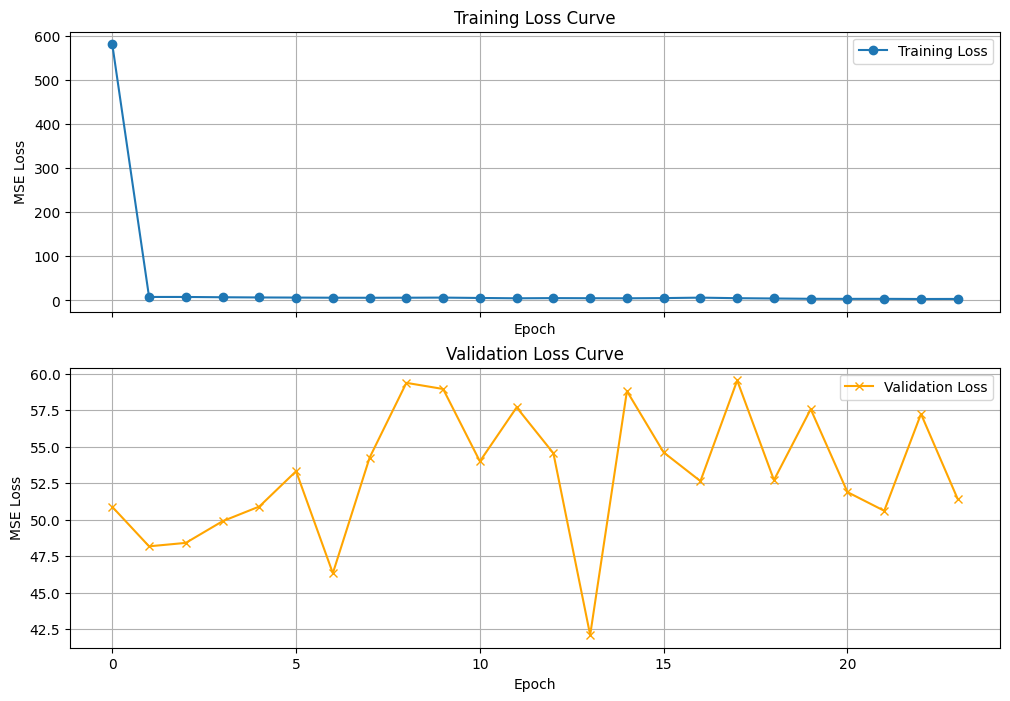

In [21]:
def train_NBEATS(train_loader, val_loader, model, loss_func, optimizer, device, feature="prices"):
    num_epochs = 100
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    epochs_without_improve = 0

    if feature == "prices":
        save_path_best = "best_nbeats_price_model.pth"
        save_path_final = "nbeats_price_model_weights_final.pth"
    else:
        save_path_best = "best_nbeats_logr_model.pth"
        save_path_final = "nbeats_logr_model_weights_final.pth"

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)   # shape: (batch_size, H*n)
            targets = targets.to(device)   # shape: (batch_size, H)

            optimizer.zero_grad()
            forecasts = model(inputs)      # forecast shape: (batch_size, H)
            loss = loss_func(forecasts, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                forecasts = model(inputs)
                loss = loss_func(forecasts, targets)
                running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

        # Early stopping: check if validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_without_improve = 0
            # Optionally save the best model here
            torch.save(model.state_dict(), save_path_best)
            print(f"    Best model weights so far saved to {save_path_best}")
        else:
            epochs_without_improve += 1
            if epochs_without_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Save the final model weights
    torch.save(model.state_dict(), save_path_final)
    print(f"    Final model weights saved to {save_path_final}")

    # Plot the training and validation loss curves
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].plot(train_losses, marker='o', label="Training Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("MSE Loss")
    axs[0].set_title("Training Loss Curve")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(val_losses, marker='x', color='orange', label="Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("MSE Loss")
    axs[1].set_title("Validation Loss Curve")
    axs[1].legend()
    axs[1].grid()

train_NBEATS(train_loader, val_loader, model, loss_func, optimizer, device, feature="prices")

Using device: cuda
Loaded best model weights from best_nbeats_price_model.pth
X_test shape: torch.Size([691, 50])
Y_test shape: torch.Size([691, 10])
Test MSE Loss: 8.6132


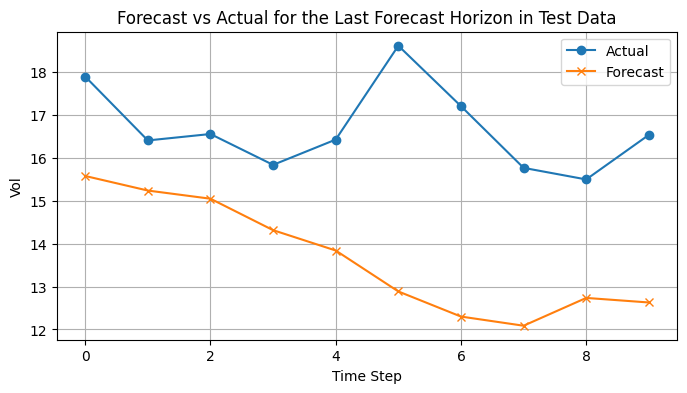

In [23]:
H = 10  # forecast horizon
n = 5   # lookback multiplier
M = 3   # number of stacks
K = 30  # number of blocks per stack

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the model architecture and load best weights
model = NBEATS(M, K, H, n).to(device)
model.load_state_dict(torch.load("best_nbeats_price_model.pth", map_location=device))
model.eval()
print("Loaded best model weights from best_nbeats_price_model.pth")

# Featurize the test series using the same H and n as training
test_series = test_data["Close"]
X_test, Y_test = featurize_series_NBEATS(test_series, H, n)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Move test data to device (we'll work on the whole tensor here for simplicity)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# Compute forecasts on the test set
with torch.no_grad():
    forecasts_test = model(X_test)  # shape: (num_samples, H)

# Compute test loss (MSE)
test_loss = nn.MSELoss()(forecasts_test, Y_test).item()
print(f"Test MSE Loss: {test_loss:.4f}")

# For visualization, let's plot the last forecast sample:
# We'll take the last sample from the test set, which corresponds to the last available forecast horizon.
last_forecast = forecasts_test[-1].cpu().numpy()
last_target = Y_test[-1].cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(range(H), last_target, marker='o', label="Actual")
plt.plot(range(H), last_forecast, marker='x', label="Forecast")
plt.xlabel("Time Step")
plt.ylabel("Vol")
plt.title("Forecast vs Actual for the Last Forecast Horizon in Test Data")
plt.legend()
plt.grid(True)
plt.show()

For the **LSTM**,

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = X_train.shape[-1]
hidden_size = 256
num_layers = 16
output_size = 1
print(X_train.shape)
seq_length = H

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
from torchinfo import summary
summary(model, input_size=(32, seq_length, input_size))

torch.Size([1965, 50])


Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─LSTM: 1-1                              [32, 10, 256]             8,210,432
├─Linear: 1-2                            [32, 1]                   257
Total params: 8,210,689
Trainable params: 8,210,689
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.63
Input size (MB): 0.06
Forward/backward pass size (MB): 0.66
Params size (MB): 32.84
Estimated Total Size (MB): 33.56

Using device: cuda
Epoch 1/100 - Train Loss: 105.2040 - Val Loss: 249.9482
    Best model weights saved to best_lstm_price_model.pth
Epoch 2/100 - Train Loss: 15.2580 - Val Loss: 200.4372
    Best model weights saved to best_lstm_price_model.pth
Epoch 3/100 - Train Loss: 14.4847 - Val Loss: 200.4174
    Best model weights saved to best_lstm_price_model.pth
Epoch 4/100 - Train Loss: 14.4949 - Val Loss: 203.0603
Epoch 5/100 - Train Loss: 14.4791 - Val Loss: 201.2450
Epoch 6/100 - Train Loss: 14.4677 - Val Loss: 202.1914
Epoch 7/100 - Train Loss: 14.4587 - Val Loss: 203.0218
Epoch 8/100 - Train Loss: 14.4428 - Val Loss: 199.5304
    Best model weights saved to best_lstm_price_model.pth
Epoch 9/100 - Train Loss: 14.4133 - Val Loss: 203.2131
Epoch 10/100 - Train Loss: 13.9400 - Val Loss: 205.4696
Epoch 11/100 - Train Loss: 12.5309 - Val Loss: 202.0303
Epoch 12/100 - Train Loss: 11.5807 - Val Loss: 184.2055
    Best model weights saved to best_lstm_price_model.pth
Epoch 13/100 - Train Loss: 

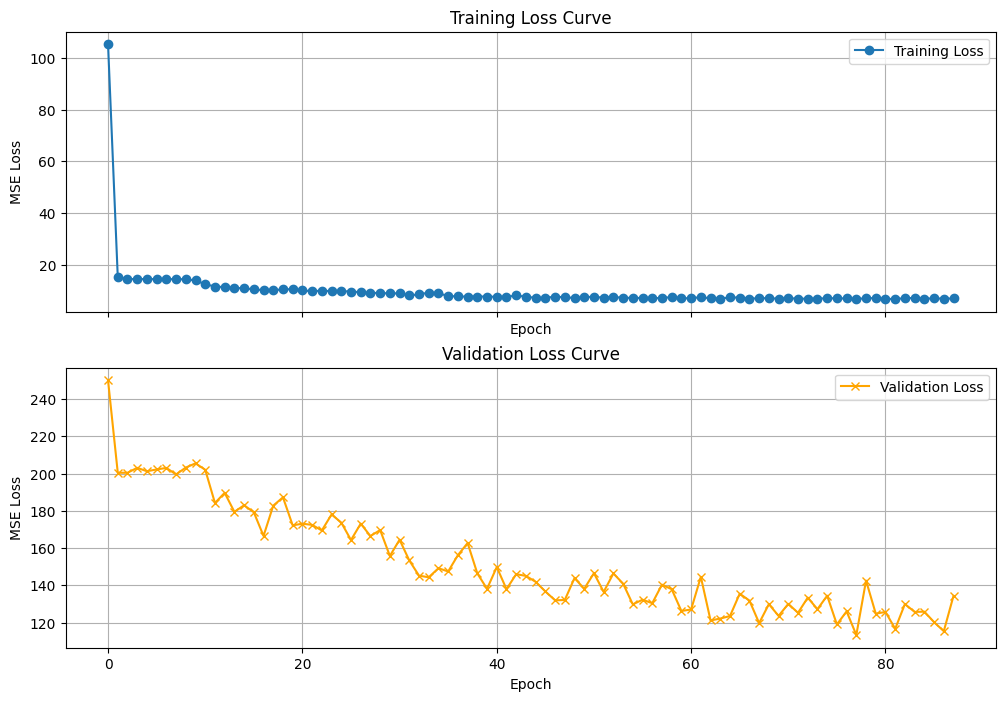

In [37]:
# Training Function
def train_LSTM(train_loader, val_loader, model, loss_func, optimizer, device, feature="prices"):
    num_epochs = 100
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    epochs_without_improve = 0

    # File names for saving model weights
    if feature == "prices":
        save_path_best = "best_lstm_price_model.pth"
        save_path_final = "lstm_price_model_weights_final.pth"
    else:
        save_path_best = "best_lstm_logr_model.pth"
        save_path_final = "lstm_logr_model_weights_final.pth"

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            # Reshape inputs for LSTM: (batch_size, sequence_length, input_size)
            inputs = inputs.unsqueeze(1)  # Adds sequence_length dimension

            forecasts = model(inputs)
            loss = loss_func(forecasts, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Ensure inputs have correct shape
                inputs = inputs.unsqueeze(1)

                forecasts = model(inputs)
                loss = loss_func(forecasts, targets)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_without_improve = 0
            torch.save(model.state_dict(), save_path_best)
            print(f"    Best model weights saved to {save_path_best}")
        else:
            epochs_without_improve += 1
            if epochs_without_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Save the final model weights
    torch.save(model.state_dict(), save_path_final)
    print(f"    Final model weights saved to {save_path_final}")

    # Plot loss curves
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].plot(train_losses, marker='o', label="Training Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("MSE Loss")
    axs[0].set_title("Training Loss Curve")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(val_losses, marker='x', color='orange', label="Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("MSE Loss")
    axs[1].set_title("Validation Loss Curve")
    axs[1].legend()
    axs[1].grid()

# Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize LSTM model
input_size = X_train.shape[1]  # 50
hidden_size = 256
num_layers = 2  # Number of LSTM layers
output_size = Y_train.shape[1]  # 10

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the LSTM model
train_LSTM(train_loader, val_loader, model, loss_func, optimizer, device, feature="prices")

Loaded best model weights from best_lstm_price_model.pth
Test MSE Loss: 33.4282


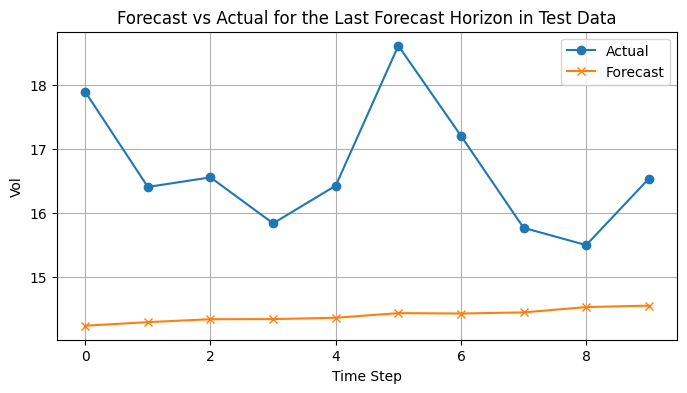

In [35]:
# Load Best Model for Testing
model.load_state_dict(torch.load("best_lstm_price_model.pth", map_location=device))
model.eval()
print("Loaded best model weights from best_lstm_price_model.pth")

# Ensure correct shape for LSTM
X_test = X_test.unsqueeze(1)  # Add sequence length dimension

# Compute forecasts on the test set
with torch.no_grad():
    forecasts_test = model(X_test)

# Compute test loss (MSE)
test_loss = nn.MSELoss()(forecasts_test, Y_test).item()
print(f"Test MSE Loss: {test_loss:.4f}")

# Plot last forecast sample
last_forecast = forecasts_test[-1].cpu().numpy()
last_target = Y_test[-1].cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(range(10), last_target, marker='o', label="Actual")
plt.plot(range(10), last_forecast, marker='x', label="Forecast")
plt.xlabel("Time Step")
plt.ylabel("Vol")
plt.title("Forecast vs Actual for the Last Forecast Horizon in Test Data")
plt.legend()
plt.grid(True)
plt.show()

### **d) Backtest**

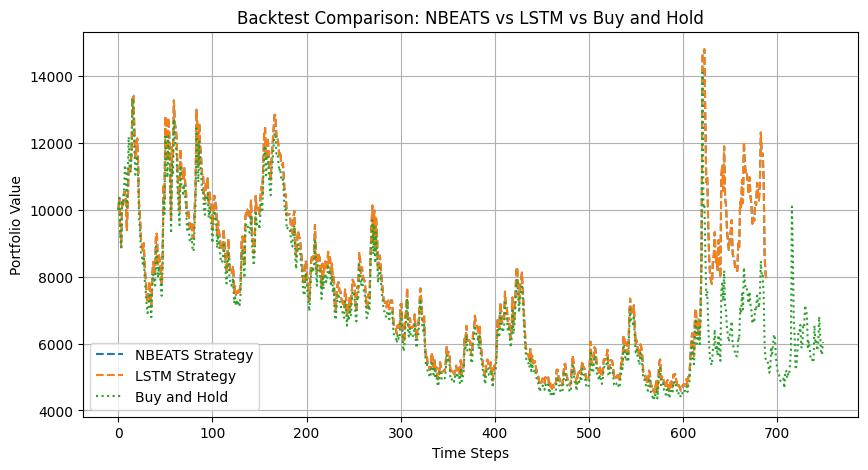

In [39]:
def backtest_strategy(forecasts, actuals, test_prices, buy_threshold=0.02, profit_target=0.05):
    capital = 10000  # Initial capital
    position = 0
    cash = capital
    buy_price = None
    portfolio_values = []
    
    for i in range(len(forecasts)):
        forecast = forecasts[i]
        actual = actuals[i]
        price = test_prices[i]
        
        if position == 0 and np.mean(forecast) > buy_threshold:  # Buy based on mean forecast
            position = cash / price  # Buy as much as possible
            buy_price = price
            cash = 0
        
        elif position > 0 and ((price - buy_price) / buy_price) >= profit_target:  # Sell signal
            cash = position * price  # Sell all
            position = 0
            buy_price = None
        
        portfolio_values.append(cash + (position * price))  # Track portfolio value
    
    return portfolio_values

# Load test prices (actual VIX index values during test period)
test_prices = test_data["Close"].values

# Backtest for NBEATS
nbeats_forecasts = forecasts_test.cpu().numpy()[:, -1]  # Last step forecast
nbeats_actuals = Y_test.cpu().numpy()[:, -1]
nbeats_results = backtest_strategy(nbeats_forecasts, nbeats_actuals, test_prices)

# Backtest for LSTM
lstm_forecasts = forecasts_test.cpu().numpy()
lstm_actuals = Y_test.cpu().numpy()
lstm_results = backtest_strategy(lstm_forecasts, lstm_actuals, test_prices)

# Buy-and-hold strategy
buy_hold_values = [10000 * (p / test_prices[0]) for p in test_prices]

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(nbeats_results, label="NBEATS Strategy", linestyle="--")
plt.plot(lstm_results, label="LSTM Strategy", linestyle="--")
plt.plot(buy_hold_values, label="Buy and Hold", linestyle="dotted")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Backtest Comparison: NBEATS vs LSTM vs Buy and Hold")
plt.legend()
plt.grid()
plt.show()

### **Step 2)**

Walk-forward backtest results with **NBEATS**:

C:\Users\Atakan\AppData\Local\Temp\ipykernel_7856\3779384079.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_hold_values = [10000 * (p / full_data[0]) for p in full_data]


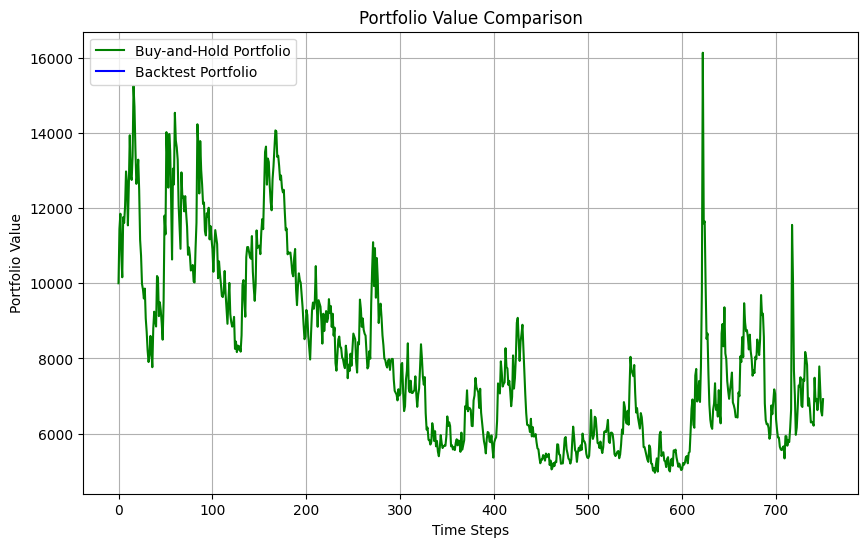

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Backtesting function for calculating portfolio values
def backtest_strategy(forecasts, actuals, test_prices, buy_threshold=0.0, profit_target=0.05):
    """
    Backtest a strategy based on forecasted values.
    
    Parameters:
        forecasts: Predicted values for the test data
        actuals: Actual values for the test data
        test_prices: Test prices used for calculating portfolio value
        buy_threshold: Forecast threshold to trigger a buy signal
        profit_target: Profit target percentage to trigger a sell signal
    
    Returns:
        portfolio_values: List of portfolio values during the backtest
    """
    portfolio_value = 10000  # Initial portfolio value
    position = 0  # 0 means no position, otherwise it's the amount of assets owned
    cash = portfolio_value
    buy_price = 0
    
    portfolio_values = [portfolio_value]
    
    for i in range(len(forecasts)):
        forecast = forecasts[i]
        actual = actuals[i]
        price = test_prices[i]
        
        # Buy signal
        if position == 0 and forecast > buy_threshold:
            position = cash / price  # Buy as much as possible
            buy_price = price
            cash = 0
        # Sell signal
        elif position > 0 and (price / buy_price - 1) >= profit_target:
            cash = position * price  # Sell the assets
            position = 0
        
        # Track portfolio value
        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)
    
    return portfolio_values

# Plotting function for buy-and-hold vs backtest portfolio values
def plot_portfolio_values(buy_hold_values, backtest_values, forecast_values, actual_values, title="Portfolio Value Comparison"):
    """
    Plots the comparison of Buy-and-Hold and Backtest portfolio values.
    
    Parameters:
        buy_hold_values: Portfolio values for buy-and-hold strategy
        backtest_values: Portfolio values from backtest strategy
        forecast_values: Forecasted values (for plotting purposes)
        actual_values: Actual values (for plotting purposes)
        title: Title for the plot
    """
    plt.figure(figsize=(10, 6))
    plt.plot(buy_hold_values, label="Buy-and-Hold Portfolio", color="green")
    plt.plot(backtest_values, label="Backtest Portfolio", color="blue")
    plt.xlabel("Time Steps")
    plt.ylabel("Portfolio Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Walk-forward training and backtesting function
def walk_forward_train_test(train_NBEATS, train_LSTM, model_type, full_data, H, n, device, feature="prices", split_type="500-500"):
    """
    Walk-forward training and backtesting for NBEATS and LSTM models.
    """
    step_size = 100 if split_type == "500-100" else 500
    train_size = 500
    test_size = 100 if split_type == "500-100" else 500
    
    all_forecasts = []
    all_actuals = []
    
    for start in range(0, len(full_data) - train_size - test_size, step_size):
        train_data = full_data[start : start + train_size]
        test_data = full_data[start + train_size : start + train_size + test_size]
        
        # Featurize data
        X_train, Y_train = featurize_series_NBEATS(train_data, H, n)
        X_test, Y_test = featurize_series_NBEATS(test_data, H, n)
        
        # Convert to PyTorch tensors
        train_dataset = TensorDataset(X_train, Y_train)
        test_dataset = TensorDataset(X_test, Y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Initialize model
        if model_type == "NBEATS":
            model = NBEATS(M=3, K=30, H=H, n=n).to(device)
            train_func = train_NBEATS
        else:
            model = LSTMModel(input_size=X_train.shape[1], hidden_size=256, num_layers=2, output_size=Y_train.shape[1]).to(device)
            train_func = train_LSTM
        
        # Define loss function and optimizer
        loss_func = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model
        train_func(train_loader, val_loader, model, loss_func, optimizer, device, feature)
        
        # Load best model
        best_model_path = f"best_{model_type.lower()}_{feature}_model.pth"
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        model.eval()
        
        # Compute forecasts on test data
        X_test = X_test.to(device)
        with torch.no_grad():
            forecasts_test = model(X_test).cpu().numpy()
            actuals_test = Y_test.cpu().numpy()
            
        all_forecasts.extend(forecasts_test)
        all_actuals.extend(actuals_test)
    
    return np.array(all_forecasts), np.array(all_actuals)

# Example usage
full_data = data["Adj Close"]  # Make sure 'data' is already loaded as your full dataset
H = 10  # Forecast horizon
n = 5   # Lookback multiplier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device

# Perform walk-forward training and backtesting with NBEATS model
forecasts, actuals = walk_forward_train_test(train_NBEATS, train_LSTM, "NBEATS", full_data, H=H, n=n, device=device, split_type="500-500")

# Generate buy-and-hold portfolio values
buy_hold_values = [10000 * (p / full_data[0]) for p in full_data]

# Generate backtest portfolio values
backtest_values = backtest_strategy(forecasts.flatten(), actuals.flatten(), full_data[500:])

# Plot portfolio comparison
plot_portfolio_values(buy_hold_values, backtest_values, forecasts.flatten(), actuals.flatten(), title="Portfolio Value Comparison")

Walk-forward backtest results with **LSTM**:

C:\Users\Atakan\AppData\Local\Temp\ipykernel_7856\809012411.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_hold_values = [10000 * (p / full_data[0]) for p in full_data]


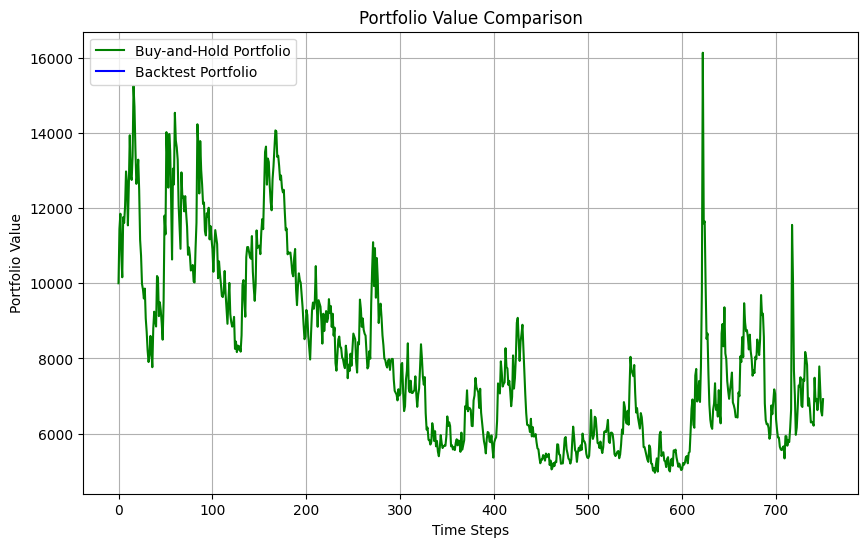

In [54]:
# Perform walk-forward training and backtesting with LSTM model
forecasts, actuals = walk_forward_train_test(train_LSTM, train_LSTM, "LSTM", full_data, H=H, n=n, device=device, split_type="500-500")

# Generate buy-and-hold portfolio values
buy_hold_values = [10000 * (p / full_data[0]) for p in full_data]

# Generate backtest portfolio values
backtest_values = backtest_strategy(forecasts.flatten(), actuals.flatten(), full_data[500:])

# Plot portfolio comparison
plot_portfolio_values(buy_hold_values, backtest_values, forecasts.flatten(), actuals.flatten(), title="Portfolio Value Comparison")